In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Pre-tratamiento

In [2]:
#Importar Dataframe que contiene el trabajo semanal en la linea de volúmenes
df_vols_trabajo_semanal = pd.read_excel('./dataframes/df_vols_trabajo_semanal.xlsx')

In [3]:
#Rellenar semanas faltantes
semana_min = df_vols_trabajo_semanal['semana_primer_dia'].min()
semana_max = df_vols_trabajo_semanal['semana_primer_dia'].max()
todas_las_semanas = pd.date_range(semana_min, semana_max, freq='W-MON')
todas_las_semanas
df_todas_las_semanas = pd.DataFrame({'semana_primer_dia': todas_las_semanas})
df_completo = pd.merge(df_todas_las_semanas, df_vols_trabajo_semanal, on='semana_primer_dia', how='left')
df_completo['cantidad_fabricada'].fillna(0, inplace=True)
df_completo['tiempo_trabajo'].fillna(0, inplace=True)
df_completo['tiempo_trabajo_horas'].fillna(0, inplace=True)
df_completo['semana'] = df_completo['semana_primer_dia'].dt.isocalendar().week.astype(str) + "-" + df_completo['semana_primer_dia'].dt.year.astype(str)
df_vols_trabajo_semanal = df_completo

## Modelo

In [4]:
df_xg = df_vols_trabajo_semanal.rename(columns={"semana_primer_dia": "ds", "tiempo_trabajo_horas": "y"})
df_xg = df_xg.drop(['semana', 'cantidad_fabricada', 'tiempo_trabajo', 'Unnamed: 0'], axis=1)
df_xg['week'] = df_xg['ds'].dt.isocalendar().week
df_xg['year'] = df_xg['ds'].dt.isocalendar().year
df_xg['month'] = df_xg['ds'].dt.month

def is_holiday(y):
    
    # Si y no es None, aplicar el criterio original
    if y < 5:
        return 1
    else:
        return 0

def is_holiday_future(ds):
    week = ds.isocalendar().week
    month = ds.month
    
    # Verificar si la semana está en las semanas 32 o 33 de agosto
    if (week == 33 or week == 34) and month == 8:
        return 1
    else:
        return 0

df_xg['holiday'] = df_xg.apply(lambda row: is_holiday(row['y']), axis=1)

df_xg.set_index('ds', inplace = True)

In [5]:
df_xg

,y,week,year,month,holiday
ds,,,,,
2021-01-04,30.810483,1,2021,1,0
2021-01-11,30.578016,2,2021,1,0
2021-01-18,42.218261,3,2021,1,0
2021-01-25,36.675983,4,2021,1,0
2021-02-01,37.119676,5,2021,2,0
...,...,...,...,...,...
2024-06-17,23.720607,25,2024,6,0
2024-06-24,24.732537,26,2024,6,0
2024-07-01,29.009952,27,2024,7,0


In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_xg['y'].values.reshape(-1, 1))

# sequence_length = 104  
sequence_length = 52  # 52 semanas, año completo HIPERPARÁMETRO
# sequence_length = 26 

#Generar los datos de entrenamiento a partir de la serie temporal completa escalada
X, y = [], []
for i in range(sequence_length, len(scaled_data)):

    data_append_X = np.concatenate([scaled_data[i-sequence_length:i, 0], df_xg.iloc[i][['year', 'month','week', 'holiday']].values])
    
    X.append(data_append_X)

    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

In [7]:
#Test Size para que haya mismos datos de entrenamiento que en los otros

df_X_xg = pd.DataFrame(X)
df_y_xg = pd.DataFrame(y)

df_X_xg = df_X_xg.apply(pd.to_numeric, errors='coerce')
df_y_xg = df_y_xg.apply(pd.to_numeric, errors='coerce')

X_train, X_test, y_train, y_test = train_test_split(df_X_xg, df_y_xg, test_size=0.12, shuffle=False, random_state=101)

### Optimización de hiperparámetros

In [8]:
# #Optimización LENTA

# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor

# # Definir el modelo base
# xgb_model = XGBRegressor(objective="reg:squarederror", eval_metric="rmse")

# # Definir el conjunto de hiperparámetros
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],   # Reducido a 3 opciones
#     'max_depth': [5, 10, 15],              # Reducido a 3 opciones
#     'subsample': [0.7, 0.8, 0.9],          # Reducido a 3 opciones
#     'colsample_bytree': [0.7, 0.8, 0.9],   # Reducido a 3 opciones
#     'n_estimators': [100, 500, 1000],       # Reducido a 3 opciones
#     'reg_alpha': [0, 0.1, 1],               # Reducido a 3 opciones
#     'reg_lambda': [0.1, 1, 10]              # Reducido a 3 opciones 
# }

# # Configurar GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_model, 
#                            param_grid=param_grid, 
#                            cv=3, 
#                            scoring='neg_mean_squared_error', 
#                            verbose=1, 
#                            n_jobs=-1)

# # Ajustar el modelo a los datos ¿¿¿¿¿¿USAR TODOS LOS DATOS???????
# grid_search.fit(X_train, y_train)

# # Revisar los mejores parámetros y RMSE
# print("Best parameters found: ", grid_search.best_params_)
# print("Best RMSE: ", (-grid_search.best_score_)**0.5)

# # Entrenar el modelo final
# best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)


In [9]:
# #Optimización RAPIDA

# from sklearn.model_selection import RandomizedSearchCV
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Definir el modelo base
# xgb_model = XGBRegressor(objective="reg:squarederror", eval_metric="rmse")

# # Definir el conjunto de hiperparámetros
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],   # Reducido a 3 opciones
#     'max_depth': [5, 10, 15],              # Reducido a 3 opciones
#     'subsample': [0.7, 0.8, 0.9],          # Reducido a 3 opciones
#     'colsample_bytree': [0.7, 0.8, 0.9],   # Reducido a 3 opciones
#     'n_estimators': [100, 500, 1000],       # Reducido a 3 opciones
#     'reg_alpha': [0, 0.1, 1],               # Reducido a 3 opciones
#     'reg_lambda': [0.1, 1, 10]              # Reducido a 3 opciones   
# }

# # Configurar RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=xgb_model, 
#                                    param_distributions=param_grid, 
#                                    n_iter=50, 
#                                    cv=3, 
#                                    scoring='neg_mean_squared_error', 
#                                    verbose=1, 
#                                    n_jobs=-1)

# # Ajustar el modelo a los datos de entrenamiento
# random_search.fit(X_train, y_train)

# # Revisar los mejores parámetros y RMSE durante la validación cruzada
# print("Best parameters found: ", random_search.best_params_)
# print("Best RMSE on cross-validation: ", (-random_search.best_score_)**0.5)

# # El mejor modelo ya está entrenado, no es necesario volver a entrenarlo
# best_model = random_search.best_estimator_

# # Evaluar el modelo en el conjunto de prueba
# y_pred = best_model.predict(X_test)

# # Calcular las métricas de rendimiento en el conjunto de prueba
# rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
# mae = mean_absolute_error(y_test, y_pred)  # MAE

# print(f"RMSE on test set: {rmse}")
# print(f"MAE on test set: {mae}")

### Evaluación

In [10]:
from xgboost import XGBRegressor

model = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    learning_rate=0.1,  # Ajustado
    max_depth=10,         # Ajustado
    subsample=0.7,       # Ajustado
    colsample_bytree=0.9, # Ajustado
    n_estimators=500,    # Ajustado
    reg_alpha=0,       # Regularización L1
    reg_lambda=1,       # Regularización L2
    early_stopping_rounds= 50
    )

In [11]:
model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=True,
)

[0]	validation_0-rmse:0.16240
[1]	validation_0-rmse:0.15671
[2]	validation_0-rmse:0.14758
[3]	validation_0-rmse:0.14544
[4]	validation_0-rmse:0.14542
[5]	validation_0-rmse:0.14468
[6]	validation_0-rmse:0.13911
[7]	validation_0-rmse:0.14321
[8]	validation_0-rmse:0.14112
[9]	validation_0-rmse:0.14383
[10]	validation_0-rmse:0.14356
[11]	validation_0-rmse:0.14535
[12]	validation_0-rmse:0.14929
[13]	validation_0-rmse:0.15281
[14]	validation_0-rmse:0.15166
[15]	validation_0-rmse:0.15470
[16]	validation_0-rmse:0.15560
[17]	validation_0-rmse:0.15621
[18]	validation_0-rmse:0.15450
[19]	validation_0-rmse:0.15696
[20]	validation_0-rmse:0.15418
[21]	validation_0-rmse:0.15558
[22]	validation_0-rmse:0.15670
[23]	validation_0-rmse:0.15761
[24]	validation_0-rmse:0.16014
[25]	validation_0-rmse:0.16167
[26]	validation_0-rmse:0.16064
[27]	validation_0-rmse:0.16024
[28]	validation_0-rmse:0.16074
[29]	validation_0-rmse:0.16173
[30]	validation_0-rmse:0.16283
[31]	validation_0-rmse:0.16277
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred_xg = model.predict(X_test)
y_test_inverted = scaler.inverse_transform(y_test.values)
y_pred_xg_inverted = scaler.inverse_transform(y_pred_xg.reshape(-1, 1))

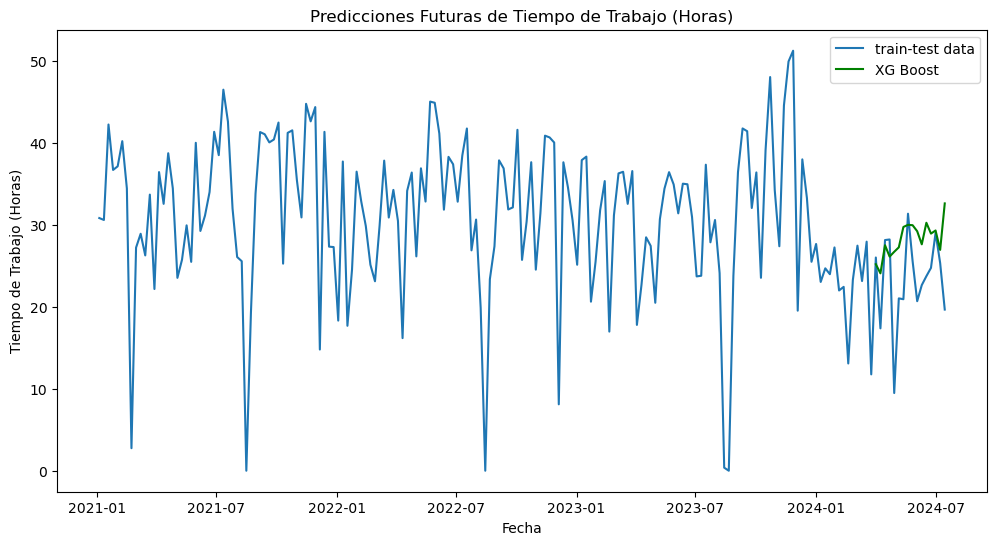

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_xg.index, df_xg['y'], label='train-test data')
fechas_pred = df_xg.index[-16:]
# Graficar los valores de y_pred_xg_inverted en las últimas 16 fechas
plt.plot(fechas_pred, y_pred_xg_inverted.flatten(), label='XG Boost', color = 'green')
plt.title('Predicciones Futuras de Tiempo de Trabajo (Horas)')
plt.xlabel('Fecha')
plt.ylabel('Tiempo de Trabajo (Horas)')
plt.legend()
plt.show()

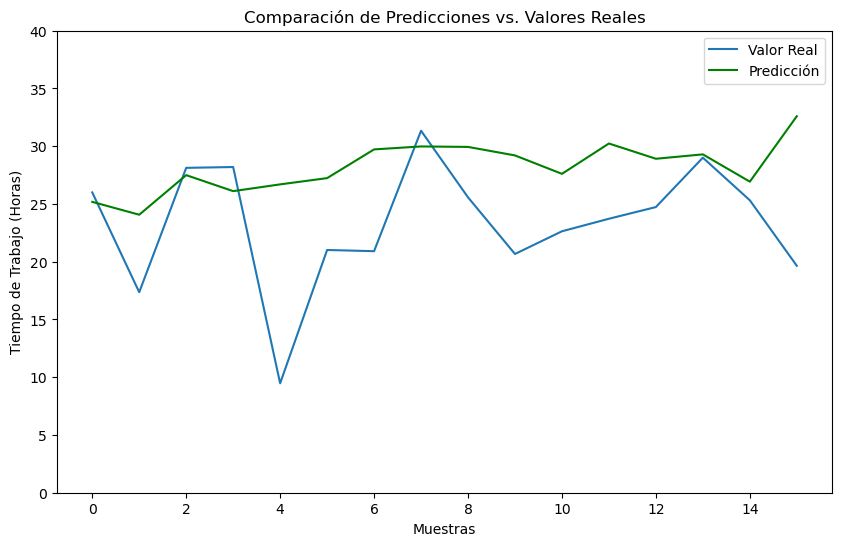

In [14]:
# Comparar predicciones con valores reales
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverted, label='Valor Real')
plt.plot(y_pred_xg_inverted, label='Predicción', color = 'green')
plt.title('Comparación de Predicciones vs. Valores Reales')
plt.xlabel('Muestras')
plt.ylabel('Tiempo de Trabajo (Horas)')
plt.ylim(0,40)
plt.legend()
plt.show()

In [15]:
#Calcular métricas de error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print ('RMSE XGBoost: ' + str(mean_squared_error(y_test_inverted, y_pred_xg_inverted) ** (1/2)))
print ('MAE XGBoost: ' + str(mean_absolute_error(y_test_inverted, y_pred_xg_inverted)))
print ('MAPE XGBoost: ' + str(mean_absolute_percentage_error(y_test_inverted, y_pred_xg_inverted)))

RMSE XGBoost: 7.1246250371923825
MAE XGBoost: 5.454768867517648
MAPE XGBoost: 0.317048812057114


In [16]:
error = pd.DataFrame(y_test_inverted-y_pred_xg_inverted)

Desvación de 0: -4.842656352118437


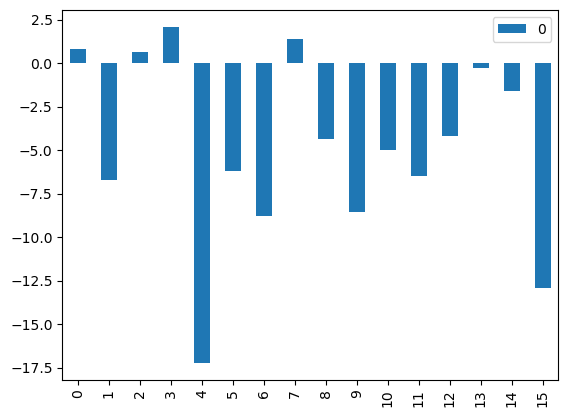

In [17]:
error.plot(kind = 'bar')
desviación_error = error.mean()
desviación_error = float(desviación_error.iloc[0])
print('Desvación de 0: ' + str(desviación_error))

In [18]:
#Compensar los valores pronosticados y recalcular:
y_pred_xg_inverted_compensado = y_pred_xg_inverted + desviación_error

#Calcular métricas de error

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print ('RMSE XGBoost: ' + str(mean_squared_error(y_test_inverted, y_pred_xg_inverted_compensado) ** (1/2)))
print ('MAE XGBoost: ' + str(mean_absolute_error(y_test_inverted, y_pred_xg_inverted_compensado)))
print ('MAPE XGBoost: ' + str(mean_absolute_percentage_error(y_test_inverted, y_pred_xg_inverted_compensado)))

RMSE XGBoost: 5.225797769503848
MAE XGBoost: 4.149344972414775
MAPE XGBoost: 0.2202088607344107


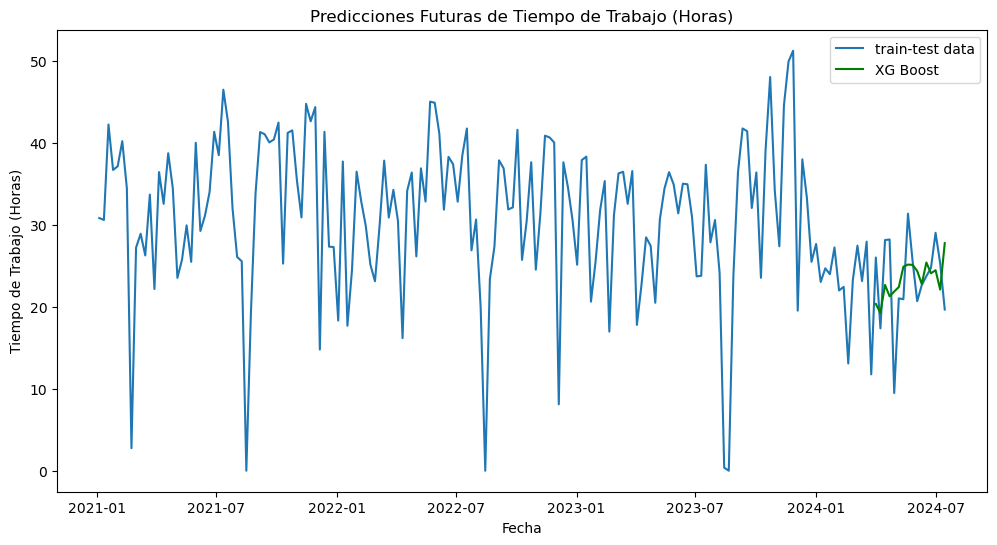

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(df_xg.index, df_xg['y'], label='train-test data')
fechas_pred = df_xg.index[-16:]
# Graficar los valores de y_pred_xg_inverted en las últimas 16 fechas
plt.plot(fechas_pred, y_pred_xg_inverted_compensado.flatten(), label='XG Boost', color = 'green')
plt.title('Predicciones Futuras de Tiempo de Trabajo (Horas)')
plt.xlabel('Fecha')
plt.ylabel('Tiempo de Trabajo (Horas)')
plt.legend()
plt.show()

### Predicciones Futuras

In [20]:
#Entrenar modelo con todos los datos:

model = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    learning_rate=0.1,  # Ajustado
    max_depth=10,         # Ajustado
    subsample=0.7,       # Ajustado
    colsample_bytree=0.9, # Ajustado
    n_estimators=500,    # Ajustado
    reg_alpha=0,       # Regularización L1
    reg_lambda=1,       # Regularización L2
    # # early_stopping_rounds= 50
    )

model.fit(
    df_X_xg, 
    df_y_xg, 
    verbose=True,
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
# Número de predicciones futuras que quieres hacer
n_pred = 16  # Por ejemplo, predecir las próximas 16 semanas

# Crear un DataFrame para almacenar las predicciones futuras
pred_futuras = pd.DataFrame(index=range(n_pred), columns=df_xg.columns)

# # Inicializar con la última secuencia de datos disponible
last_sequence = scaled_data[-sequence_length:]

# Modificar la lógica de predicción para incluir la nueva condición de 'holiday'
for i in range(n_pred):
    # Calcular la fecha de la predicción actual
    current_date = df_xg.index[-1] + pd.Timedelta(weeks=i+1)

    # Extraer el año, mes, semana y calcular si es un feriado
    current_year = current_date.year
    current_month = current_date.month
    current_week = current_date.isocalendar().week
    current_holiday = is_holiday_future(current_date) 

    # Concatenar la secuencia de datos con las características temporales actualizadas
    input_sequence = np.concatenate([last_sequence.flatten(), [current_year, current_month, current_week, current_holiday]])

    input_sequence = input_sequence.reshape(1, -1)
    
    next_prediction = model.predict(input_sequence)
    next_prediction_inverted = scaler.inverse_transform(next_prediction.reshape(-1, 1))[0][0]

    # Guardar los resultados en el DataFrame de predicciones futuras
    pred_futuras.loc[i, 'y'] = next_prediction_inverted
    pred_futuras.loc[i, 'ds'] = current_date
    pred_futuras.loc[i, 'year'] = current_year
    pred_futuras.loc[i, 'month'] = current_month
    pred_futuras.loc[i, 'week'] = current_week
    pred_futuras.loc[i, 'holiday'] = current_holiday

    # Actualizar la secuencia para la próxima predicción
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_prediction

# Imprimir las predicciones futuras
print(pred_futuras)
pred_futuras_compensadas = pred_futuras.copy()
pred_futuras_compensadas['y'] = pred_futuras_compensadas['y'] + desviación_error

            y week  year month holiday         ds
0   22.757475   30  2024     7       0 2024-07-22
1   23.621624   31  2024     7       0 2024-07-29
2   22.754509   32  2024     8       0 2024-08-05
3    3.734621   33  2024     8       1 2024-08-12
4    6.124433   34  2024     8       1 2024-08-19
5   22.235069   35  2024     8       0 2024-08-26
6   24.285355   36  2024     9       0 2024-09-02
7   31.830591   37  2024     9       0 2024-09-09
8   33.303383   38  2024     9       0 2024-09-16
9   25.125042   39  2024     9       0 2024-09-23
10  23.727985   40  2024     9       0 2024-09-30
11  24.437008   41  2024    10       0 2024-10-07
12  32.648178   42  2024    10       0 2024-10-14
13  30.228914   43  2024    10       0 2024-10-21
14   24.19129   44  2024    10       0 2024-10-28
15  21.230301   45  2024    11       0 2024-11-04


In [22]:
def limitar_cero(valor):
    return max(0, valor)
    
pred_futuras_compensadas['y'] = pred_futuras_compensadas['y'].apply(limitar_cero)

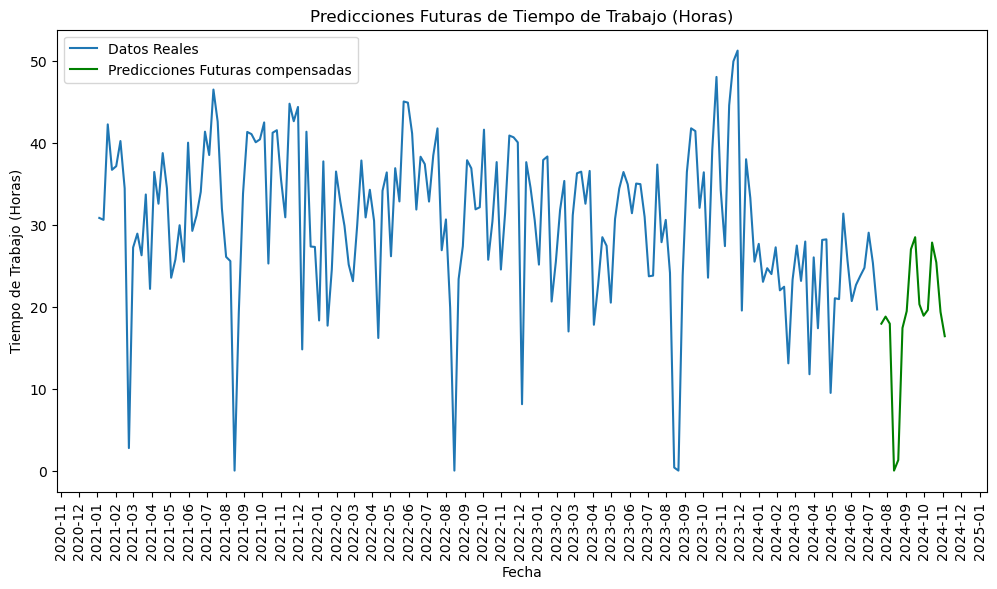

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(df_xg.index, df_xg['y'], label='Datos Reales')
# plt.plot(pred_futuras['ds'], pred_futuras['y'], label='Predicciones Futuras', color='orange')
plt.plot(pred_futuras['ds'], pred_futuras_compensadas['y'], label='Predicciones Futuras compensadas', color='green')
plt.title('Predicciones Futuras de Tiempo de Trabajo (Horas)')
plt.xlabel('Fecha')
plt.ylabel('Tiempo de Trabajo (Horas)')
plt.legend()

# Configuración de las etiquetas de fecha
plt.xticks(rotation=90)  # Gira las fechas 90 grados
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Muestra cada mes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato de año-mes

plt.show()


In [24]:
y_pred_XGBoost = pred_futuras_compensadas[['ds', 'y']].rename(columns={'y': 'yhat'})

In [25]:
y_pred_XGBoost.to_excel('./predictions/y_pred_XGBoost.xlsx')